In [99]:
# import libraries

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# cleaning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# exploration
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import levene, ttest_ind

# modeling
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score

# 1.1 Data Cleaning: Load Data

In [100]:
# load spam.csv into dataframe
spam = pd.read_csv("spam.csv", encoding="latin-1")
spam.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [101]:
# drop empty columns and rename v1 and v2
spam["target"] = spam.v1
spam["text"] = spam.v2

for col in spam.columns:
    if (col != "target") & (col != "text"):
        spam.drop(col, axis=1, inplace=True)
        
spam.head()

target                                               text
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

# 1.2 See if classes are balanced

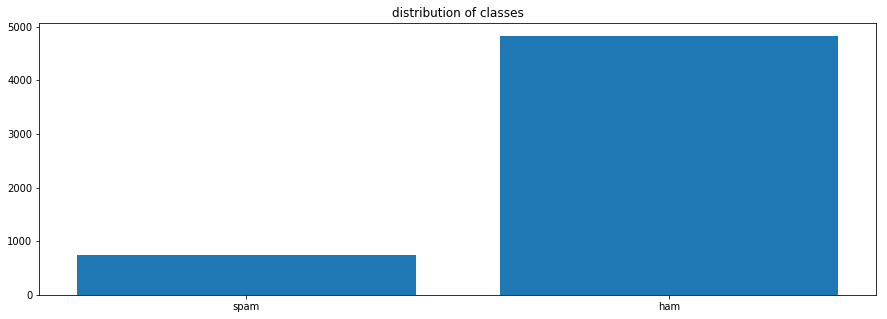

In [102]:
# get value counts
value_counts = dict(spam.target.value_counts())

# plot class distribution
plt.figure(figsize=(15, 5))
plt.bar(["spam", "ham"], [value_counts["spam"], value_counts["ham"]])
plt.title("distribution of classes")
plt.show()

Most of the data is ham. So I will use a stratified split

# 1.3 Train / Test Split

In [103]:
# stratified split
sss = StratifiedShuffleSplit(test_size = 0.2, random_state=42)
train_index, test_index = next(sss.split(spam.text, spam.target))

len(train_index), len(test_index)

(4457, 1115)

In [104]:
# use indices to split the data
train = spam.iloc[train_index]
test = spam.iloc[test_index]

In [105]:
# check value counts to ensure a quality split
print(train.target.value_counts(normalize=True))
print(test.target.value_counts(normalize=True))

ham     0.865829
spam    0.134171
Name: target, dtype: float64
ham     0.866368
spam    0.133632
Name: target, dtype: float64


# 1.4 Check for duplicate values

From this point on I am only inspecting the training set. However I will apply changes to both sets as needed. 

In [106]:
train.duplicated().sum()

265

In [107]:
# drop duplicates from both train and test sets

train = train.drop_duplicates()
test = test.drop_duplicates()

# 2.1 Exploratory Data Analysis: Checking Top Words

Now I will which words have the highest count value in spam and ham messages. 

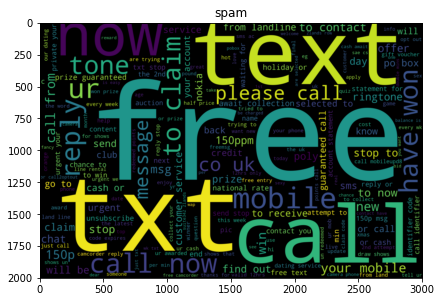

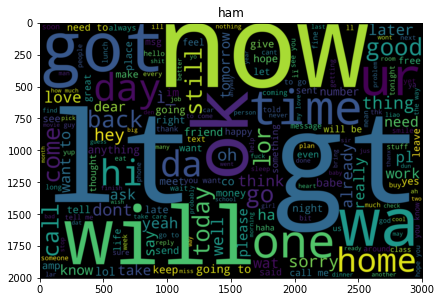

In [108]:
# seperate ham from spam
spam = train[train.target == "spam"].text
ham = train[train.target == "ham"].text

# function for wordclouds
def to_wordcloud(articles, title):
    
    string_of_words = " ".join(articles)
    string_of_words = string_of_words.lower()
    
    wc = WordCloud(width = 3000, height = 2000)
    
    plt.imshow(wc.generate(string_of_words), interpolation="bilinear")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()
    
    
# word clouds   
to_wordcloud(spam, "spam")

print("\n\n\n")

to_wordcloud(ham, "ham")

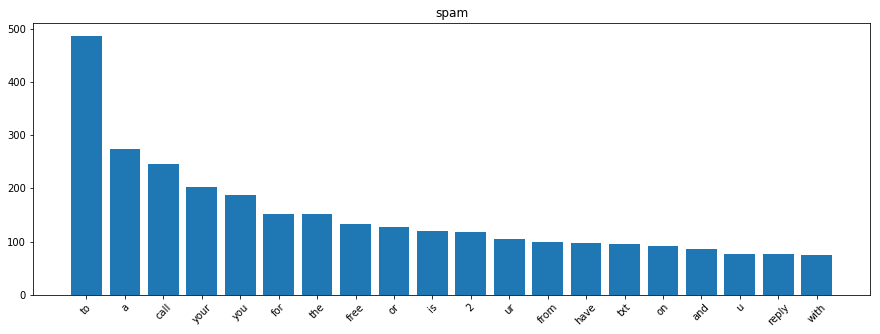

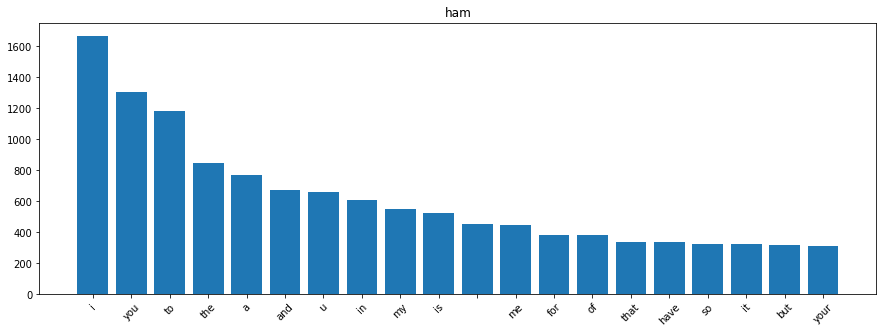

In [109]:
# function for bar graphs
def plot_word_count(articles, title):
    
    string_of_words = " ".join(articles)
    string_of_words = string_of_words.lower()
    collection = string_of_words.split(" ")
    
    cnt = Counter(collection)
    words = [i[0] for i in cnt.most_common(20)]
    counts = [i[1] for i in cnt.most_common(20)]
    
    plt.figure(figsize=(15, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
# bar grapgs
plot_word_count(spam, "spam")

print("\n\n\n")

plot_word_count(ham, "ham")

We can see that the words "you" and "call" are high in both. Spam has more of the words "txt" and "reply". Ham is distinguished by the word "I".

# 2.2 Explore length as a factor.

Now I will create a new feature "len" that measures the length of the message. I will check to see how the length of the message correlates with the class (spam or ham). Also, I will now one-hot-encode the target variable.

In [110]:
# one hot encode target

#train
ohe_target_train = train.target.map(lambda x: 0 if x=="spam" else 1)
train.drop("target", axis=1, inplace=True)
train["target"] = ohe_target_train

#test
ohe_target_test = test.target.map(lambda x: 0 if x=="spam" else 1)
test.drop("target", axis=1, inplace=True)
test["target"] = ohe_target_test

In [111]:
# create "len" feature
train["len"] = train["text"].map(len)
train.head()

text  target  len
184                          Going on nothing great.bye       1   26
2171                      I wont. So wat's wit the guys       1   29
5422            Ok k..sry i knw 2 siva..tats y i askd..       1   39
4113  Where are you ? What do you do ? How can you s...       1  154
4588       Have you not finished work yet or something?       1   44

In [112]:
# test correlation
train.corr()

target     len
target  1.0000 -0.3824
len    -0.3824  1.0000

The correlation isn't too high. I will now use a t-test to see if there is a statistcally significant difference in length between spam and ham messages. To decide which t-test to use I will use a levene test to examine the difference in variances. For the levene test the null hypothesis will be that the variances are the same, and the alternative hypothesis will be that they are different. The alpha value will be 0.05

In [113]:
# leven test
levene(train.target, train["len"])

LeveneResult(statistic=3780.649897608388, pvalue=0.0)

The p-value is below 0.05 so we can reject the null hypothesis and assume the variances are significantly different. So now I will use a welch's t-test. The null hypothesis will be that the length of the message does not vary significantly between spam and ham messages. The alternative hypothesis will be that the length of the message varies significantly between spam and ham messages. The alpha value will be 0.05

In [114]:
ttest_ind(train[train.target == 1]["len"], train[train.target == 0]["len"], equal_var=False)

Ttest_indResult(statistic=-42.27182480244643, pvalue=4.1600411376224655e-241)

The p-value is above 0.05, so we can say there is no significant difference between the lengths of spam and ham messages. This means that I should not use length as a feature in my model. I will now remove the "len" column

In [115]:
# drop len column
train.drop("len", axis=1, inplace=True)
train.head()

text  target
184                          Going on nothing great.bye       1
2171                      I wont. So wat's wit the guys       1
5422            Ok k..sry i knw 2 siva..tats y i askd..       1
4113  Where are you ? What do you do ? How can you s...       1
4588       Have you not finished work yet or something?       1

# 3.1 Modeling: Preprocessing

In the modeling stage of this project I will try out several machine learning models to see which performs the best on the training set. I will be using cross validation to get an estimate of performance. To turn the text into a numerical data type I will be using tf-idf. This stands for term frequency / inter-document frequency. Tf-idf is essentially a measure of how much a word is correlated to a class. I will be using a grid search to tune the hyper-paramaters. The models I will test are: logistic regression, support-vector-machine, decision-tree, random-forest, and K-nearest-neighbors. I will be using f1-score, precision, and recall as the performance metrics, with recall being more important, because it is better to have spam leak through than to have important messages blocked as spam.

In [117]:
# preprocess data into td-idf matrices

# split X and y
X_train, y_train = train.text, train.target
X_test, y_test = test.text, test.target

# td-idf vectorize
vectorizer = TfidfVectorizer(tokenizer=word_tokenize)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# 3.2 Logistic Regression

Now I will go through the modeling process using Logistic Regression. First I will look at the baseline results.

In [118]:
# save model
clf = LogisticRegression()

# create a function to print scores
def scores(y_true, y_hat):
    
    print("f1", f1_score(y_true, y_hat))
    print("precision", precision_score(y_true, y_hat))
    print("recall", recall_score(y_true, y_hat))
    return None

# find baseline results
baseline = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
baseline

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'fit_time': array([0.01097083, 0.00898337, 0.00897264, 0.00797915, 0.00799537]),
 'score_time': array([0.00299191, 0.00196099, 0.00199342, 0.00299835, 0.00199676]),
 'test_f1': array([0.97991968, 0.97531688, 0.97658863, 0.97398266, 0.97142857]),
 'train_f1': array([0.98335295, 0.98319328, 0.98368377, 0.98385469, 0.98302806]),
 'test_precision': array([0.96062992, 0.95182292, 0.95549738, 0.95052083, 0.94444444]),
 'train_precision': array([0.96725108, 0.96694215, 0.96821192, 0.96822244, 0.9666226 ]),
 'test_recall': array([1.        , 1.        , 0.99863201, 0.99863201, 1.        ]),
 'train_recall': array([1.        , 1.        , 0.99965812, 1.        , 1.        ])}

It seems the precision score is excellent on the baseline logistic regression model. I will experiment with the hyperparameters to see if I can increase the recall.

In [119]:
# hyper parameter tuning

params = {"C":[0.01, 0.1, 0.5, 1, 5, 10]}
gs = GridSearchCV(clf, params, cv=5, return_train_score=True, scoring="f1")
gs.fit(X_train, y_train)

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)

In [120]:
# check new parameters
gs.best_params_

{'C': 10}

In [121]:
# measure new scores
tuned = cross_validate(gs.best_estimator_, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
tuned

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'fit_time': array([0.01396179, 0.01196766, 0.01097083, 0.00897574, 0.00897336]),
 'score_time': array([0.0039947 , 0.00299239, 0.00302553, 0.00299072, 0.00199413]),
 'test_f1': array([0.98852127, 0.98650472, 0.98578199, 0.98583951, 0.98384926]),
 'train_f1': array([0.99880444, 0.99880485, 0.99829352, 0.99863435, 0.99880485]),
 'test_precision': array([0.97730307, 0.97336884, 0.97587131, 0.97207447, 0.96821192]),
 'train_precision': array([0.99761174, 0.99761255, 0.99659284, 0.99727242, 0.99761255]),
 'test_recall': array([1.        , 1.        , 0.99589603, 1.        , 1.        ]),
 'train_recall': array([1., 1., 1., 1., 1.])}

The model seems to do even better.

In [122]:
# save scores for logistic regression
model_comparison = {}
model_comparison["LogisticRegression"] = tuned

# 3.3 Support Vector Classifier

Now I will go through the same process with a support vector machine classifier.

In [123]:
# save model
clf = SVC(gamma="auto", kernel="linear")

# find baseline results
baseline = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
baseline

{'fit_time': array([0.42087269, 0.41485357, 0.42287374, 0.41788197, 0.41292715]),
 'score_time': array([0.28025079, 0.28028989, 0.28223586, 0.28025031, 0.30216122]),
 'test_f1': array([0.99052774, 0.99051491, 0.98778833, 0.98917456, 0.9851752 ]),
 'train_f1': array([0.99778195, 0.99727242, 0.99778271, 0.99812319, 0.99744246]),
 'test_precision': array([0.98123324, 0.98120805, 0.97981157, 0.97858099, 0.97078353]),
 'train_precision': array([0.99557371, 0.99455967, 0.99557522, 0.99625341, 0.99489796]),
 'test_recall': array([1.        , 1.        , 0.99589603, 1.        , 1.        ]),
 'train_recall': array([1., 1., 1., 1., 1.])}

The support vector machine looks promising. I don't think tuning it will make it any better.

In [125]:
# save scores
model_comparison["SVC"] = baseline

# 3.4 Decision Tree

Now I will move on to the tree based algorithms, starting with the decision tree.

In [126]:
# find baseline scores
clf = DecisionTreeClassifier()

baseline = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
baseline

{'fit_time': array([0.19048572, 0.21243072, 0.18949509, 0.17752647, 0.17952037]),
 'score_time': array([0.00302386, 0.00299001, 0.00398374, 0.0029912 , 0.00398874]),
 'test_f1': array([0.97750511, 0.98226467, 0.97945205, 0.97693351, 0.97275204]),
 'train_f1': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.9755102 , 0.97959184, 0.98079561, 0.96904441, 0.9687924 ]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([0.9795082 , 0.98495212, 0.97811218, 0.98495212, 0.97674419]),
 'train_recall': array([1., 1., 1., 1., 1.])}

The model seems to be overfitting due to too little bias. Observe how the testing precision changes by 10 percentile based on which split is being tested. I will see if lowering the max depth fixes the problem.

In [127]:
# hyper parameter tuning

params = {"max_depth":[2,3]}
gs = GridSearchCV(clf, params, cv=5, return_train_score=True, scoring="f1")
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', 

In [128]:
gs.best_params_

{'max_depth': 3}

In [129]:
tuned = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
tuned

{'fit_time': array([0.19053006, 0.19052172, 0.1875    , 0.17654109, 0.18147349]),
 'score_time': array([0.00399375, 0.00399184, 0.00299358, 0.00398779, 0.0039897 ]),
 'test_f1': array([0.97400821, 0.98362892, 0.9795082 , 0.97564276, 0.97414966]),
 'train_f1': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.97534247, 0.98095238, 0.9781719 , 0.96519411, 0.96887686]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([0.9726776 , 0.98632011, 0.98084815, 0.98632011, 0.97948016]),
 'train_recall': array([1., 1., 1., 1., 1.])}

While the over fitting problem got somewhat better, the model just isn't performing that well. Perhaps the ensemble method will work better.

# 3.5 Random Forest

In [130]:
# find baseline scores
clf = RandomForestClassifier()

baseline = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
baseline

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: Future

{'fit_time': array([0.17656779, 0.17153287, 0.16354823, 0.1725378 , 0.17149949]),
 'score_time': array([0.01097035, 0.01097083, 0.00997353, 0.01097131, 0.01097083]),
 'test_f1': array([0.98451178, 0.98184264, 0.9844909 , 0.98186702, 0.98184264]),
 'train_f1': array([0.99880444, 0.99897541, 0.99914603, 0.99948744, 0.99982909]),
 'test_precision': array([0.97078353, 0.96560847, 0.97074468, 0.96437995, 0.96560847]),
 'train_precision': array([0.99761174, 0.99795292, 0.99829352, 0.99897541, 0.99965824]),
 'test_recall': array([0.99863388, 0.99863201, 0.99863201, 1.        , 0.99863201]),
 'train_recall': array([1., 1., 1., 1., 1.])}

The model seems to be over fitting. I will adjust the n_estimators to 200.

In [131]:
# tune hyper-parameters and check scores
clf = clf.set_params(n_estimators=200)

tuned = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring=["f1", "precision", "recall"])
tuned

{'fit_time': array([3.3909297 , 3.61234403, 3.75193238, 3.23534584, 3.54156184]),
 'score_time': array([0.1585753 , 0.1486063 , 0.1515944 , 0.14560986, 0.14361525]),
 'test_f1': array([0.98785425, 0.98451178, 0.98250336, 0.98120805, 0.97661991]),
 'train_f1': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.976     , 0.96949602, 0.96688742, 0.96310935, 0.95430809]),
 'train_precision': array([1., 1., 1., 1., 1.]),
 'test_recall': array([1.        , 1.        , 0.99863201, 1.        , 1.        ]),
 'train_recall': array([1., 1., 1., 1., 1.])}

Random Forest performs well, but not as good as the SVM.

# 4.1 Modeling Analysis

Lets first take a look at the scores.

In [133]:
model_comparison

{'LogisticRegression': {'fit_time': array([0.01396179, 0.01196766, 0.01097083, 0.00897574, 0.00897336]),
  'score_time': array([0.0039947 , 0.00299239, 0.00302553, 0.00299072, 0.00199413]),
  'test_f1': array([0.98852127, 0.98650472, 0.98578199, 0.98583951, 0.98384926]),
  'train_f1': array([0.99880444, 0.99880485, 0.99829352, 0.99863435, 0.99880485]),
  'test_precision': array([0.97730307, 0.97336884, 0.97587131, 0.97207447, 0.96821192]),
  'train_precision': array([0.99761174, 0.99761255, 0.99659284, 0.99727242, 0.99761255]),
  'test_recall': array([1.        , 1.        , 0.99589603, 1.        , 1.        ]),
  'train_recall': array([1., 1., 1., 1., 1.])},
 'SVC': {'fit_time': array([0.42087269, 0.41485357, 0.42287374, 0.41788197, 0.41292715]),
  'score_time': array([0.28025079, 0.28028989, 0.28223586, 0.28025031, 0.30216122]),
  'test_f1': array([0.99052774, 0.99051491, 0.98778833, 0.98917456, 0.9851752 ]),
  'train_f1': array([0.99778195, 0.99727242, 0.99778271, 0.99812319, 0.9974

It looks like the support vector machine worked the best, so lets examine the coefficients to the model.

In [175]:
# fit support vector machine

# save model
clf = SVC(gamma="auto", kernel="linear")

# fit
clf.fit(X_train, y_train)

# get coefficients
coefs = clf.coef_.toarray()[0]
print(len(coefs), coefs[:10])

8707 [-0.97287306  0.51175506 -0.31451965 -0.40260317 -0.8954207  -0.01248366
 -0.27066321  0.00618317  0.06391458  0.        ]


In [176]:
# get feature names
names = vectorizer.get_feature_names()
names[20:25]

["'luxury", "'m", "'maangalyam", "'married", "'melle"]

In [178]:
# combine coeficients and feature names in a dictionary
names_coefs = dict(zip(names, coefs))

In [179]:
names_coefs

{'!': -0.9728730589077194,
 '#': 0.5117550636903045,
 '$': -0.31451965380929153,
 '%': -0.4026031699932091,
 '&': -0.8954206995054138,
 "'": -0.012483655735522577,
 "''": -0.27066320598726956,
 "''ok": 0.006183169799853229,
 "'an": 0.06391457889686161,
 "'anything": 0.0,
 "'comfort": 0.0,
 "'d": 0.22430657456767578,
 "'doctors": 0.0,
 "'heart": 0.0,
 "'help": -0.22994098669950438,
 "'hex": 0.0,
 "'hw": 0.0,
 "'if": 0.0,
 "'its": 0.057259655411489696,
 "'ll": 0.2336586083185257,
 "'luxury": 0.0,
 "'m": 0.16256635432169012,
 "'maangalyam": 0.197417685168035,
 "'married": 0.0,
 "'melle": 0.06916655949796766,
 "'need": 0.0,
 "'re": -0.0938843162914282,
 "'rencontre": 0.0,
 "'s": 0.11804216527557373,
 "'simple": 0.0,
 "'taxless": 0.0,
 "'terrorist": 0.06400850014652959,
 "'that": 0.0,
 "'til": 0.0,
 "'uptown": -0.25895353348948924,
 "'ve": 0.08335575793770557,
 "'wnevr": 0.0,
 "'xam": 0.0,
 '(': -0.9248939006381598,
 ')': 0.6495664241718633,
 '*': 0.2792430672413267,
 '*****': -0.0269365200

In [183]:
# find top 30 feature names based on absolute value of coef

# create a placeholder list to hold most important feature names
top_feat_names = []
top_coefs = []

# sort the dictionary's items
sort_names = sorted(names_coefs.items(), key=lambda x: x[1])

# get top 10 and bottom 10 feature names
for name, coef in sort_names[:10]:
    top_feat_names.append(name)
    top_coefs.append(coef)
    
for name, coef in sort_names[-11:]:
    top_feat_names.append(name)
    top_coefs.append(coef)
    

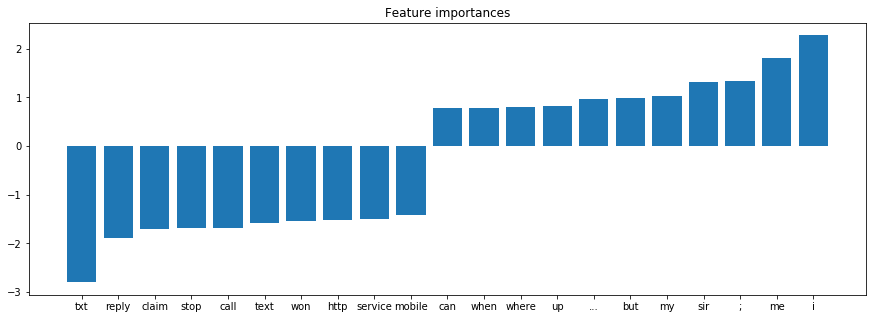

In [187]:
# plot the coefficients with the feature names
plt.figure(figsize=(15, 5))
# use dictionary to find coefficients
plt.bar(top_feat_names, top_coefs)
plt.title("Feature importances")
plt.show()

The higher the value of the bar in the graph, the higher the likelihood it is a real text, and vice-versa. It seems that the word "sir" is an indicator of a real text. I doubt anyone would have guessed that if it weren't for the analysis. We can see here that alot of spam messages contain a hyperlink.